# 2. Download a ResNet 50 trained on the ImageNet classification dataset, 
a. Use the features extracted from the last fully-connected layer and train
binary SVM classifier for a category [from CIFAR-10 categories] of your
choice. Report the following

- Accuracy, Confusion Matrix on test data. 
- ROC curve (assuming the chosen class as positive class and
remaining classes as negative) 

In [2]:
# Importing library


import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
# Downloading and Loading Data Set

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50000,shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Initializing GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


##a. Use the features extracted from the last fully-connected layer and train binary SVM classifier for a category [from CIFAR-10 categories] of your choice. Report the following

- Accuracy, Confusion Matrix on test data. 
- ROC curve (assuming the chosen class as positive class and
remaining classes as negative) 

In [5]:
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
net.to(device)
for param in net.parameters():
    param.requires_grad = False


Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Passing Train Data from Resnet

In [6]:
with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)

In [7]:
# Setting labels of class 2 to 1 and rest to 0
# Bird Class versus rest Classification
for i in range(labels.shape[0]):
  if (labels[i] != 2):
    labels[i] = 0
  else:
    labels[i] = 1
print(labels)

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')


Passing Train Data from SVM

In [8]:
x = np.array(outputs.cpu())
l = np.array(labels.cpu())

clf = make_pipeline(StandardScaler(),LinearSVC(random_state = 0, tol=1e-5))
clf.fit(x[:25000],l[:25000])

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearsvc',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=0,
                           tol=1e-05, verbose=0))],
         verbose=False)

In [9]:
#Passing Test data from Resnet
with torch.no_grad():
    for data in testloader:
        imagesTest, labelsTest = data[0].to(device), data[1].to(device)
        outputsTest = net(imagesTest)

for i in range(labelsTest.shape[0]):
  if (labelsTest[i] != 2):
    labelsTest[i] = 0
  else:
    labelsTest[i] = 1
print(labelsTest)

c = np.array(outputsTest.cpu())
d = np.array(labelsTest.cpu())

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')


In [10]:
# Finding Accuracy Using Test Data
total = 0
correct = 0

confusion_matrix = [[0,0],[0,0]]

tpr = []
fpr = []


y_pred = clf.predict(c)

for i in range(10000):

  #Calculating TPR and FPR after 100 sample
  t = confusion_matrix[0][0]/(confusion_matrix[0][0] + confusion_matrix[0][1] +0.0001)
  f = confusion_matrix[0][1]/(confusion_matrix[1][1] + confusion_matrix[0][1]+ 0.0001)

  tpr.append(t)
  fpr.append(f)

  confusion_matrix[d[i]][y_pred[i]] += 1
  if (y_pred[i]==d[i]):
    correct +=1
  total +=1

print('-------Confusion Matrix-------')
for i in confusion_matrix:
  for j in i:
    print(j,end='   ')
  print()

Accuracy = (correct/total)*100
print('Accuracy on test data is :', Accuracy)

-------Confusion Matrix-------
8717   283   
803   197   
Accuracy on test data is : 89.14


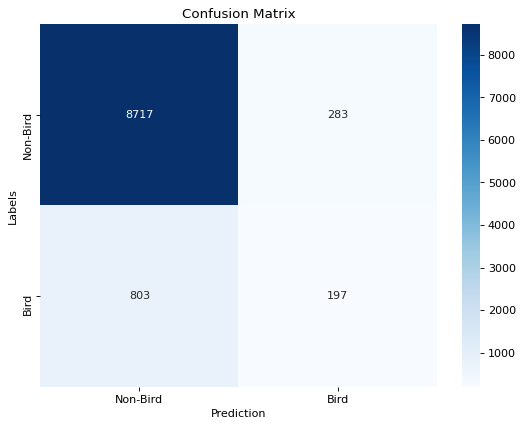

In [11]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')


x_axis_labels= ['Non-Bird','Bird']
y_axis_labels= ['Non-Bird','Bird']


sn.heatmap(confusion_matrix, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels,cmap='Blues', fmt='g')
plt.xlabel("Prediction")
plt.ylabel("Labels")
plt.title('Confusion Matrix')
plt.savefig('./Confusion_matrix')
plt.show()



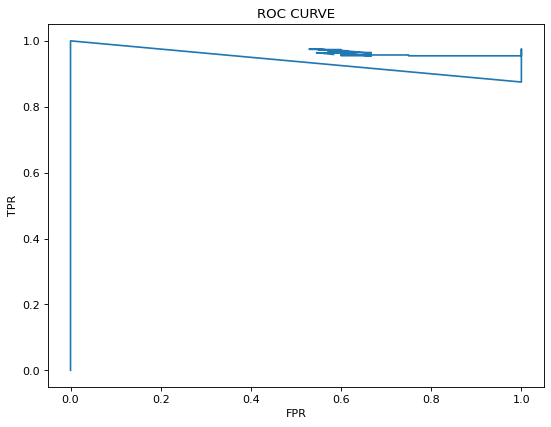

In [14]:
# ROC CURVE {receiver operating characteristic curve}
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(fpr[:500],tpr[:500])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC CURVE')
plt.savefig('./ROC_CURVE')
plt.show()








In [17]:
from  sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_pred, d)

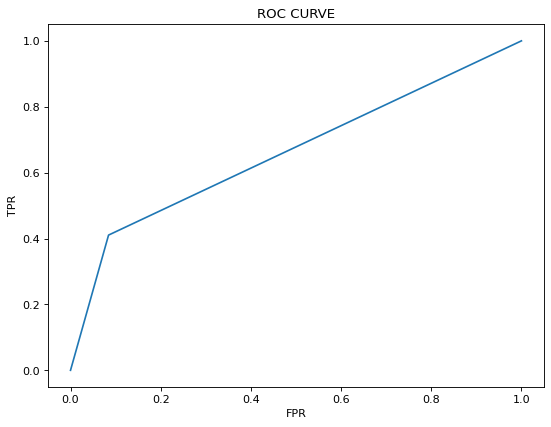

In [18]:
 # ROC CURVE {receiver operating characteristic curve}
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(fpr,tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC CURVE')
plt.savefig('./ROC_CURVE')
plt.show()
